# MC Dropout homoscedastic heteroscedastic

## Advanced topics on machine learning
 UNIVERSIDAD TECNOLÓGICA DE PEREIRA
 
Mauricio A. Álvarez Phd

TA: Cristian D. Guarnizo PhD and Hernan F. García PhD (c)


In [1]:
#!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
#!pip3 install torchvision


! pip install GPy
import GPy
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim.sgd import SGD

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from google.colab import files
%config InlineBackend.figure_format = 'svg'

     |████████████████████████████████| 993kB 2.8MB/s 
     |████████████████████████████████| 71kB 25.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/96/ee/cd/1c4dd7df63246b1e8de58af6d4457b7aed13509fdc0c918a13
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz


In [2]:
torch.cuda.device(0)
torch.cuda.get_device_name(torch.cuda.current_device())

'Tesla T4'

In [0]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [0]:
def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma)
    
    return -(log_coeff + exponent).sum()


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

In [0]:
class MC_Dropout_Layer(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_prob):
        super(MC_Dropout_Layer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout_prob = dropout_prob
        
        self.weights = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.01, 0.01))
        self.biases = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.01, 0.01))
        
    def forward(self, x):
        
        dropout_mask = torch.bernoulli((1 - self.dropout_prob)*torch.ones(self.weights.shape)).cuda()
        
        return torch.mm(x, self.weights*dropout_mask) + self.biases

In [0]:
class MC_Dropout_Model(nn.Module):
    def __init__(self, input_dim, output_dim, no_units, init_log_noise):
        super(MC_Dropout_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.layer1 = nn.Linear(input_dim, no_units)
        self.layer2 = nn.Linear(no_units, output_dim)
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
        self.log_noise = nn.Parameter(torch.cuda.FloatTensor([init_log_noise]))

    
    def forward(self, x):
        
        x = x.view(-1, self.input_dim)
        
        x = self.layer1(x)
        x = self.activation(x)
        
        x = F.dropout(x, p=0.5, training=True)
        
        x = self.layer2(x)
        
        return x

In [0]:
class MC_Dropout_Wrapper:
    def __init__(self, input_dim, output_dim, no_units, learn_rate, batch_size, no_batches, weight_decay, init_log_noise):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = MC_Dropout_Model(input_dim = input_dim, output_dim = output_dim,
                                        no_units = no_units, init_log_noise = init_log_noise)
        self.network.cuda()
        
        self.optimizer = torch.optim.SGD(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        
        output = self.network(x)
        loss = self.loss_func(output, y, torch.exp(self.network.log_noise), 1)/len(x)
        
        loss.backward()
        self.optimizer.step()

        return loss

In [8]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)


k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points)*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_train = y[75:325]

num_epochs, batch_size, nb_train = 2000, len(x_train), len(x_train)

net = MC_Dropout_Wrapper(input_dim = 1, output_dim=1, no_units=200, learn_rate=1e-2,
                         batch_size=batch_size, no_batches=1, init_log_noise=0, weight_decay=1e-2)

for i in range(num_epochs):
    
    loss = net.fit(x_train, y_train)
    
    if i % 200 == 0:
        print('Epoch: %4d, Train loss = %7.3f, noise = %6.3f' % \
              (i, loss.cpu().data.numpy(), torch.exp(net.network.log_noise).cpu().data.numpy()))

Epoch:    0, Train loss =   1.196, noise =  1.014
Epoch:  200, Train loss =   0.128, noise =  0.748
Epoch:  400, Train loss =   0.010, noise =  0.650
Epoch:  600, Train loss =   0.064, noise =  0.608
Epoch:  800, Train loss =  -0.057, noise =  0.582
Epoch: 1000, Train loss =  -0.074, noise =  0.569
Epoch: 1200, Train loss =  -0.144, noise =  0.551
Epoch: 1400, Train loss =  -0.100, noise =  0.542
Epoch: 1600, Train loss =  -0.129, noise =  0.536
Epoch: 1800, Train loss =  -0.165, noise =  0.534


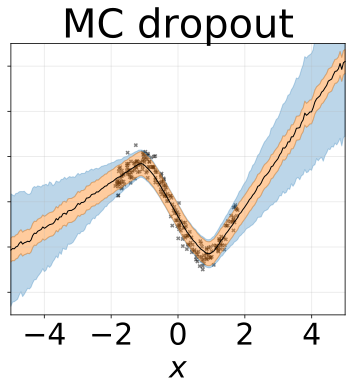

In [9]:
samples = []
noises = []
for i in range(1000):
    preds = net.network.forward(torch.linspace(-5, 5, 200).cuda()).cpu().data.numpy()
    samples.append(preds)
    
samples = np.array(samples)
means = (samples.mean(axis = 0)).reshape(-1)

aleatoric = torch.exp(net.network.log_noise).cpu().data.numpy()
epistemic = (samples.var(axis = 0)**0.5).reshape(-1)
total_unc = (aleatoric**2 + epistemic**2)**0.5


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200), means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
plt.fill_between(np.linspace(-5, 5, 200), means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200), means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = 'Aleatoric')
plt.plot(np.linspace(-5, 5, 200), means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=30)
plt.title('MC dropout', fontsize=40)
plt.tick_params(labelsize=30)
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 7, 2))
plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.savefig('mc_dropout.pdf', bbox_inches = 'tight')

files.download("mc_dropout.pdf")

plt.show()